In [1]:
import pandas as pd
from obspy.core.event import read_events
import matplotlib.pyplot as plt

import seisbench.models as sbm
import torch
import torch.nn as nn

import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding
import numpy as np
from torch.utils.data import DataLoader

import wandb
import os
import sys

from pathlib import Path
project_path = str(Path.cwd().parent)
sys.path.append(project_path)
from scripts import train

wandb: Currently logged in as: kmilian (epos). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/krystynamilian/.netrc


In [2]:
run = wandb.init(project="training_seisbench_models_on_igf_data", entity="epos", mode="online")
artifact = run.use_artifact('epos/model-registry/phasenet_p:v0', type='model')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


# Load model, get data loaders

In [3]:
model = train.load_model()

In [4]:
artifact_dir

'./artifacts/model:v4'

In [5]:
fname = artifact_dir + "/" + os.listdir(artifact_dir)[0]
# fname 
# fname = "../models/PhaseNet_pretrained_on_iquique_finetuned_on_igf_1.pt"

In [6]:
model.load_state_dict(torch.load(fname))
model.eval()

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [7]:
train_gen, dev_gen, test_gen = train.get_data_generators()

train (12444, 17) 100
using random window
dev (2773, 17) 100
using random window
test (2785, 17) 100
using random window


In [8]:
def plot_sample(sample, model, i): 
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle("Predictions for test sample: " + str(i))
    axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3,  2]})
    axs[0].plot(sample["X"][0].T, label='x')
    plt.legend()
    axs[1].plot(sample["y"][0].T, label='y')
    
    model.eval()  # close the model for evaluation
    
    with torch.no_grad():
        pred = model(torch.tensor(sample["X"], device=model.device).unsqueeze(0))  # Add a fake batch dimension
        pred = pred[0].cpu().numpy()
        pick_idx = np.argmax(pred[0])
        print(pred.shape)
    
        axs[1].plot(pred[0], label='pred', color='orange')
        plt.legend()
        
        plt.show()
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2, 3001)


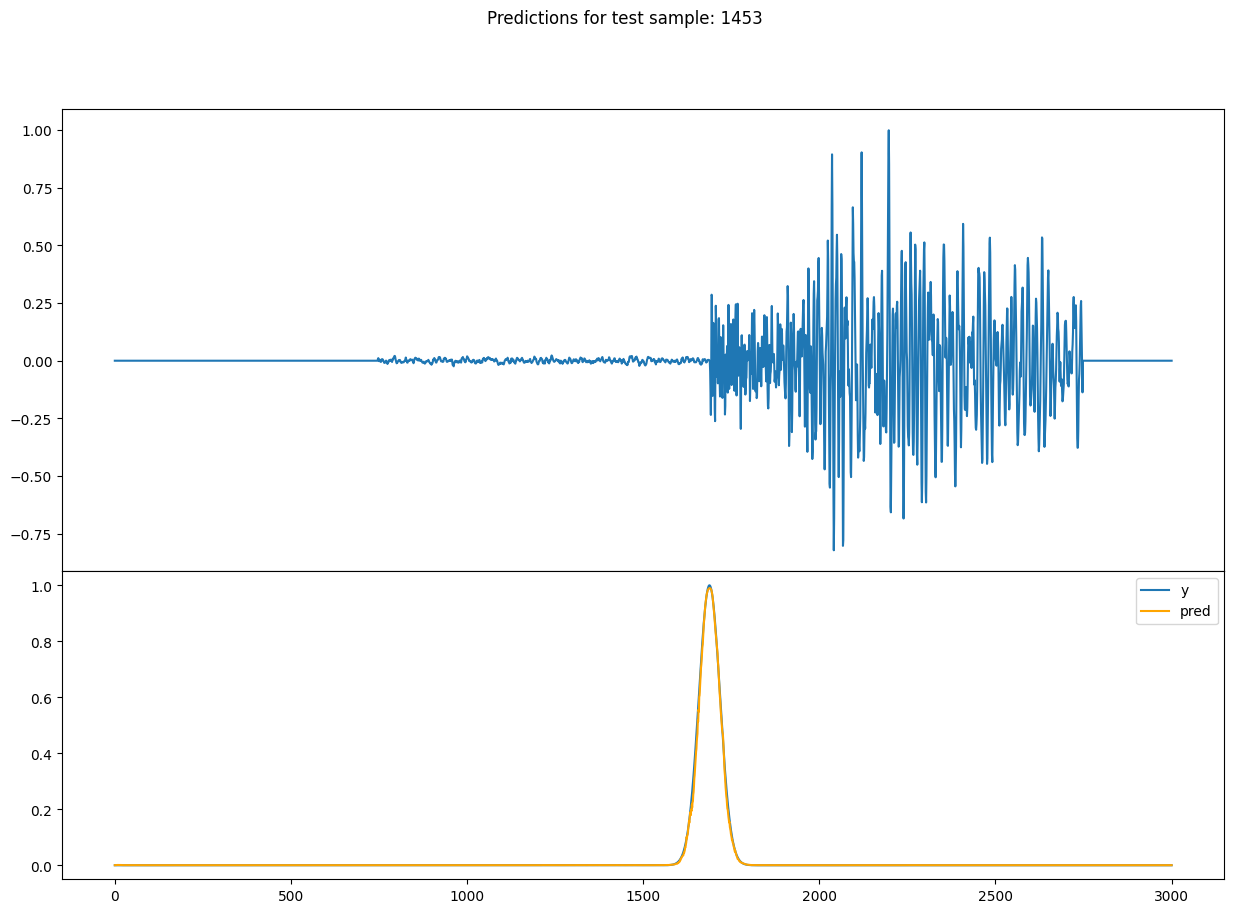

In [9]:
idx = np.random.randint(len(test_gen))
sample = test_gen[idx]
plot_sample(sample, model, idx)

